# HNet Token Chunking Visualization

This notebook demonstrates how HNet's routing module dynamically chunks DNA sequences based on cosine similarity between adjacent token embeddings.

## Key Concepts

1. **Routing Module**: Uses cosine similarity between adjacent token embeddings to determine chunk boundaries
2. **Dynamic Chunking**: Chunk sizes vary based on semantic similarity of adjacent tokens
3. **Boundary Detection**: Low cosine similarity → high boundary probability → chunk boundary
4. **Compression**: Long sequences are compressed into fewer, semantically meaningful chunks
/workspace/outputs_inocras/pretrain/hg38/caduceus-hnet_seqlen-k_d_model-256_n_enc_layer-2_n_main_layer-8_n_dec_layer-2_lr-8e-3_tokenizer_type-default

In [1]:
import sys
import os
sys.path.append('/workspace/caduceus_proj')

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from vis_tokens import HNetRoutingVisualizer
from train import SequenceLightningModule
from omegaconf import OmegaConf

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")

print("Imports successful!")


/venv/tokenize/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Imports successful!


In [2]:
# Load model using the exact configuration from model_config.json
import json
import hydra
from caduceus_hnet.modeling_caduceus_hnet import CaduceusHNet
from caduceus_hnet.configuration_caduceus_hnet import CaduceusHNetConfig
from caduceus.tokenization_caduceus import CaduceusTokenizer

# Load model using the same approach as training script
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Paths
base_config_path = "/workspace/outputs_inocras/pretrain/hg38/caduceus-hnet_seqlen-k_d_model-256_n_enc_layer-2_n_main_layer-8_n_dec_layer-2_lr-8e-3_tokenizer_type-default/model_config.json"
base_checkpoint_path = "/workspace/outputs_inocras/pretrain/hg38/caduceus-hnet_seqlen-k_d_model-256_n_enc_layer-2_n_main_layer-8_n_dec_layer-2_lr-8e-3_tokenizer_type-default/checkpoints/test/loss.ckpt"

motif_config_path = "/workspace/outputs_inocras/pretrain/hg38/caduceus-hnet_seqlen-k_d_model-256_n_enc_layer-2_n_main_layer-8_n_dec_layer-2_lr-8e-3_tokenizer_type-default-motif/model_config.json"
motif_checkpoint_path = "/workspace/outputs_inocras/pretrain/hg38/caduceus-hnet_seqlen-k_d_model-256_n_enc_layer-2_n_main_layer-8_n_dec_layer-2_lr-8e-3_tokenizer_type-default-motif/checkpoints/test/loss.ckpt"

def load_visualizer(config_path, checkpoint_path):

    print(f"Config path: {config_path}")
    print(f"Checkpoint path: {checkpoint_path}")
    print(f"Checkpoint exists: {os.path.exists(checkpoint_path)}")

    print("Loading model configuration...")
    with open(config_path, 'r') as f:
        model_config = json.load(f)

    print(f"Model config keys: {list(model_config.keys())}")

    # Create the model config using hydra instantiation
    config = hydra.utils.instantiate(model_config['config'])
    print(f"Model config created: {type(config).__name__}")

    print("Creating model...")
    model = CaduceusHNet(config)

    print("Loading checkpoint...")
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    state_dict = checkpoint['state_dict']

    # Load the state dict
    model.load_state_dict(state_dict, strict=False)

    # Move to device
    model = model.to(device)
    model.eval()

    print(f"✓ Model loaded successfully!")
    print(f"Model type: {type(model).__name__}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Create tokenizer
    tokenizer = CaduceusTokenizer(model_max_length=512)
    print(f"Tokenizer type: {type(tokenizer).__name__}")

    # Check if model has routing module and create visualizer
    print("Checking model structure...")
    print(f"Model attributes: {[attr for attr in dir(model) if not attr.startswith('_')]}")

    visualizer = HNetRoutingVisualizer(tokenizer, model.backbone, device)
    return visualizer

visualizer_base = load_visualizer(base_config_path, base_checkpoint_path)
visualizer_motif = load_visualizer(motif_config_path, motif_checkpoint_path)



Using device: cuda
Config path: /workspace/outputs_inocras/pretrain/hg38/caduceus-hnet_seqlen-k_d_model-256_n_enc_layer-2_n_main_layer-8_n_dec_layer-2_lr-8e-3_tokenizer_type-default/model_config.json
Checkpoint path: /workspace/outputs_inocras/pretrain/hg38/caduceus-hnet_seqlen-k_d_model-256_n_enc_layer-2_n_main_layer-8_n_dec_layer-2_lr-8e-3_tokenizer_type-default/checkpoints/test/loss.ckpt
Checkpoint exists: True
Loading model configuration...
Model config keys: ['config']
Model config created: CaduceusHNetConfig
Creating model...


Loading checkpoint...
✓ Model loaded successfully!
Model type: CaduceusHNet
Model parameters: 5,991,936
Tokenizer type: CaduceusTokenizer
Checking model structure...
Model attributes: ['T_destination', 'active_adapter', 'active_adapters', 'add_adapter', 'add_memory_hooks', 'add_model_tags', 'add_module', 'apply', 'assisted_decoding', 'backbone', 'base_model', 'base_model_prefix', 'beam_sample', 'beam_search', 'bfloat16', 'buffers', 'call_super_init', 'can_generate', 'children', 'compile', 'compute_transition_scores', 'config', 'config_class', 'constrained_beam_search', 'contrastive_search', 'cpu', 'create_extended_attention_mask_for_decoder', 'cuda', 'device', 'disable_adapters', 'disable_input_require_grads', 'double', 'dtype', 'dummy_inputs', 'dump_patches', 'enable_adapters', 'enable_input_require_grads', 'estimate_tokens', 'eval', 'extra_repr', 'float', 'floating_point_ops', 'forward', 'framework', 'from_pretrained', 'generate', 'generation_config', 'get_adapter_state_dict', 'get_b

In [3]:
import random
from Bio import SeqIO

# Read the FASTA file
sequences = []
for record in SeqIO.parse('/workspace/caduceus_proj/data/hg38/hg38.ml.fa', 'fasta'):
    sequences.append(str(record.seq))

print(f'Found {len(sequences)} sequences in the FASTA file')

# Extract 10 random sequences of length 1000
random_sequences = []
for i in range(10):
    # Pick a random sequence
    seq = random.choice(sequences)
    # Pick a random start position
    start = random.randint(0, len(seq) - 1000)
    # Extract 1000 bp
    random_seq = seq[start:start+1000]
    # ensure the sequence is NOT consisted of only N's
    if all(base in ['A', 'T', 'C', 'G'] for base in random_seq):
        random_sequences.append(random_seq)
        print(f'Sequence {i+1}: {random_seq[:50]}... (length: {len(random_seq)})')

Found 23 sequences in the FASTA file
Sequence 1: GCTGCTGTTCCCTGCTCTTCCCTCCTTTCCCCAACTACACCTTGACCTCC... (length: 1000)
Sequence 2: GCTTACAACATGGGCTGCCACTGTTTTTCTTGTGAGGCATGTCAGACCAG... (length: 1000)
Sequence 3: TTTCTACATATGGCTAGCCAGTTTTCCCAGCACCATTTATTAAATAGGGA... (length: 1000)
Sequence 4: AATAAATTAGATGCTGATGCATTAAATGTCCGCTTCAAGAGACTTGGCAA... (length: 1000)
Sequence 5: CACCCTGAAAAAATGACTTTAAAGATTTGAATGATAATATGACCTCTCAA... (length: 1000)
Sequence 6: TCACAAGGACAGAAAACCAAACACTGCACGTTCTCACTCATAGGTGGGAA... (length: 1000)
Sequence 7: GAGTTTTGGCTGTGGGTCTGAGCCAAAGAAACAACAAATAATGAGGACCT... (length: 1000)
Sequence 8: TTTTTTTTTTTTTTTTTTTTTTTTTTTTTGAGACAAGGTCTGGCTCTGTC... (length: 1000)
Sequence 9: TCTGGCTGGGTGAGAGGAAGGGCTGTGTCGTGCAGCTTGGGGCAGAGTCA... (length: 1000)
Sequence 10: TCTTAATAGAAGTAGTGATGTATACCTCATAAAATTGTAATGAGGTTTTA... (length: 1000)


In [4]:
# Analyze all random sequences and collect chunk length data
all_chunk_lengths = []
all_compression_ratios = []
sequence_results = []

print("Analyzing sequences...")
for i, rand_seq in enumerate(random_sequences):
    print(f"Analyzing sequence {i+1}...")
    try:
        result = visualizer_base.analyze_sequence(rand_seq, max_length=1024)
        all_chunk_lengths.extend(result.chunk_lengths)
        compression_ratio = len(rand_seq) / len(result.chunks)
        all_compression_ratios.append(compression_ratio)
        sequence_results.append({
            'sequence_id': i+1,
            'sequence_length': len(rand_seq),
            'num_chunks': len(result.chunks),
            'chunk_lengths': result.chunk_lengths,
            'compression_ratio': compression_ratio,
            'mean_chunk_length': np.mean(result.chunk_lengths),
            'std_chunk_length': np.std(result.chunk_lengths)
        })
        print(f"  ✓ {len(result.chunks)} chunks, compression: {compression_ratio:.2f}x")
    except Exception as e:
        print(f"  ✗ Error: {e}")

print(f"\nTotal chunks analyzed: {len(all_chunk_lengths)}")
print(f"Average compression ratio: {np.mean(all_compression_ratios):.2f}x")


Analyzing sequences...
Analyzing sequence 1...


  ✓ 135 chunks, compression: 7.41x
Analyzing sequence 2...
  ✓ 111 chunks, compression: 9.01x
Analyzing sequence 3...
  ✓ 109 chunks, compression: 9.17x
Analyzing sequence 4...
  ✓ 107 chunks, compression: 9.35x
Analyzing sequence 5...
  ✓ 140 chunks, compression: 7.14x
Analyzing sequence 6...
  ✓ 126 chunks, compression: 7.94x
Analyzing sequence 7...
  ✓ 129 chunks, compression: 7.75x
Analyzing sequence 8...
  ✓ 116 chunks, compression: 8.62x
Analyzing sequence 9...
  ✓ 118 chunks, compression: 8.47x
Analyzing sequence 10...
  ✓ 90 chunks, compression: 11.11x

Total chunks analyzed: 1181
Average compression ratio: 8.60x


In [5]:
# Compare chunking between base and motif visualizers
all_chunk_lengths_base = []
all_chunk_lengths_motif = []
all_compression_ratios_base = []
all_compression_ratios_motif = []
sequence_results = []

print("Analyzing sequences with both visualizers...")
for i, rand_seq in enumerate(random_sequences):
    print(f"Analyzing sequence {i+1}...")
    
    # Analyze with base visualizer
    try:
        result_base = visualizer_base.analyze_sequence(rand_seq, max_length=1024)
        all_chunk_lengths_base.extend(result_base.chunk_lengths)
        compression_ratio_base = len(rand_seq) / len(result_base.chunks)
        all_compression_ratios_base.append(compression_ratio_base)
        print(f"  Base: {len(result_base.chunks)} chunks, compression: {compression_ratio_base:.2f}x")
    except Exception as e:
        print(f"  Base ✗ Error: {e}")
        result_base = None
    
    # Analyze with motif visualizer
    try:
        result_motif = visualizer_motif.analyze_sequence(rand_seq, max_length=1024)
        all_chunk_lengths_motif.extend(result_motif.chunk_lengths)
        compression_ratio_motif = len(rand_seq) / len(result_motif.chunks)
        all_compression_ratios_motif.append(compression_ratio_motif)
        print(f"  Motif: {len(result_motif.chunks)} chunks, compression: {compression_ratio_motif:.2f}x")
    except Exception as e:
        print(f"  Motif ✗ Error: {e}")
        result_motif = None
    
    # Store results for comparison
    sequence_results.append({
        'sequence_id': i+1,
        'sequence_length': len(rand_seq),
        'base_chunks': len(result_base.chunks) if result_base else 0,
        'motif_chunks': len(result_motif.chunks) if result_motif else 0,
        'base_chunk_lengths': result_base.chunk_lengths if result_base else [],
        'motif_chunk_lengths': result_motif.chunk_lengths if result_motif else [],
        'base_compression_ratio': compression_ratio_base if result_base else 0,
        'motif_compression_ratio': compression_ratio_motif if result_motif else 0,
        'base_mean_chunk_length': np.mean(result_base.chunk_lengths) if result_base else 0,
        'motif_mean_chunk_length': np.mean(result_motif.chunk_lengths) if result_motif else 0,
    })

print(f"\n=== COMPARISON SUMMARY ===")
print(f"Base visualizer - Total chunks: {len(all_chunk_lengths_base)}, Avg compression: {np.mean(all_compression_ratios_base):.2f}x")
print(f"Motif visualizer - Total chunks: {len(all_chunk_lengths_motif)}, Avg compression: {np.mean(all_compression_ratios_motif):.2f}x")


Analyzing sequences with both visualizers...
Analyzing sequence 1...
  Base: 135 chunks, compression: 7.41x
  Motif: 218 chunks, compression: 4.59x
Analyzing sequence 2...
  Base: 111 chunks, compression: 9.01x
  Motif: 201 chunks, compression: 4.98x
Analyzing sequence 3...


  Base: 109 chunks, compression: 9.17x
  Motif: 176 chunks, compression: 5.68x
Analyzing sequence 4...
  Base: 107 chunks, compression: 9.35x
  Motif: 226 chunks, compression: 4.42x
Analyzing sequence 5...
  Base: 140 chunks, compression: 7.14x
  Motif: 230 chunks, compression: 4.35x
Analyzing sequence 6...
  Base: 126 chunks, compression: 7.94x
  Motif: 194 chunks, compression: 5.15x
Analyzing sequence 7...
  Base: 129 chunks, compression: 7.75x
  Motif: 178 chunks, compression: 5.62x
Analyzing sequence 8...
  Base: 116 chunks, compression: 8.62x
  Motif: 175 chunks, compression: 5.71x
Analyzing sequence 9...
  Base: 118 chunks, compression: 8.47x
  Motif: 206 chunks, compression: 4.85x
Analyzing sequence 10...
  Base: 90 chunks, compression: 11.11x
  Motif: 234 chunks, compression: 4.27x

=== COMPARISON SUMMARY ===
Base visualizer - Total chunks: 1181, Avg compression: 8.60x
Motif visualizer - Total chunks: 2038, Avg compression: 4.96x


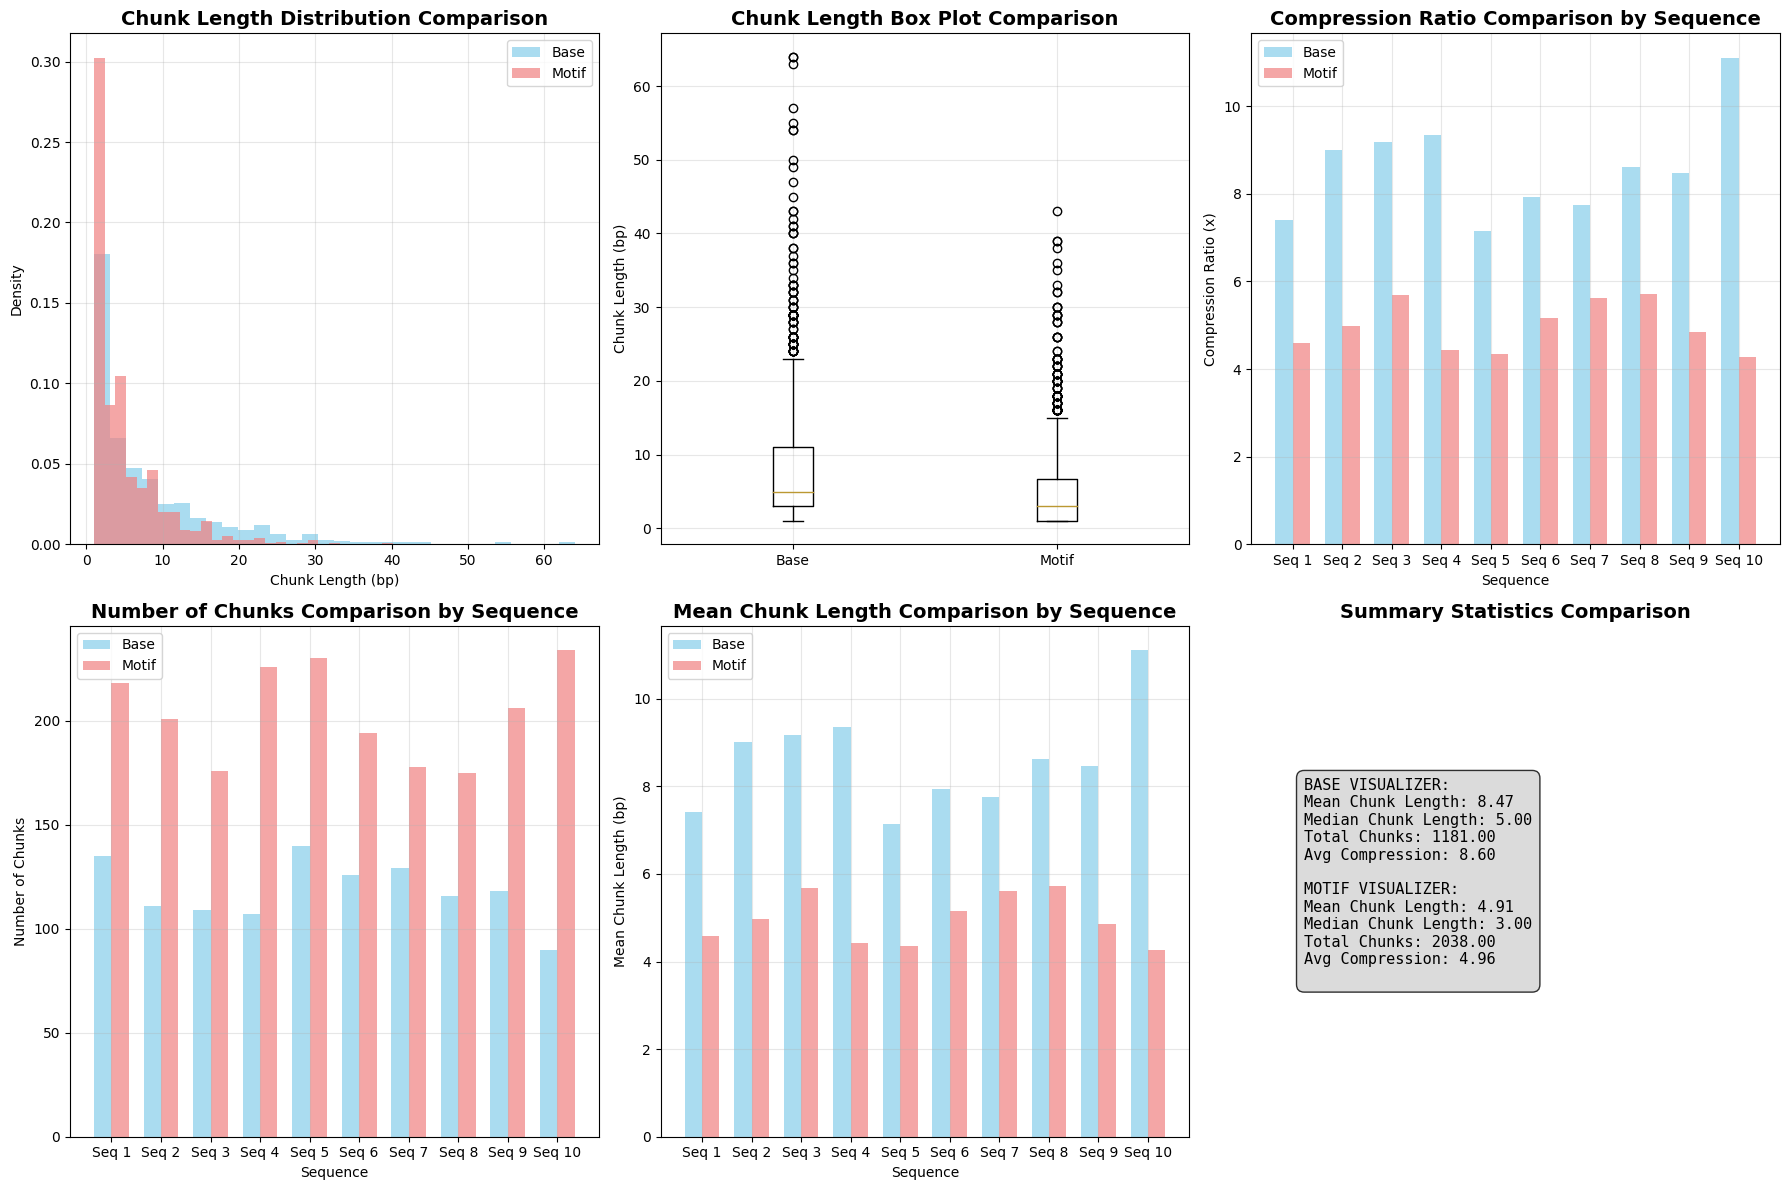


=== DETAILED COMPARISON ===
Base visualizer:
  - Mean chunk length: 8.47 bp
  - Median chunk length: 3.00 bp
  - Total chunks: 1181
  - Average compression: 8.60x

Motif visualizer:
  - Mean chunk length: 4.91 bp
  - Median chunk length: 3.00 bp
  - Total chunks: 2038
  - Average compression: 4.96x

Difference (Motif - Base):
  - Chunk length difference: -3.56 bp
  - Total chunks difference: 857
  - Compression ratio difference: -3.63x


In [6]:
# Visualize comparison between base and motif visualizers
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Histogram comparison of chunk lengths
axes[0, 0].hist(all_chunk_lengths_base, bins=30, alpha=0.7, color='skyblue', label='Base', density=True)
axes[0, 0].hist(all_chunk_lengths_motif, bins=30, alpha=0.7, color='lightcoral', label='Motif', density=True)
axes[0, 0].set_title('Chunk Length Distribution Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Chunk Length (bp)')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Box plot comparison
chunk_data = [all_chunk_lengths_base, all_chunk_lengths_motif]
axes[0, 1].boxplot(chunk_data, labels=['Base', 'Motif'])
axes[0, 1].set_title('Chunk Length Box Plot Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Chunk Length (bp)')
axes[0, 1].grid(True, alpha=0.3)

# 3. Compression ratio comparison per sequence
sequence_ids = [seq['sequence_id'] for seq in sequence_results]
base_compression = [seq['base_compression_ratio'] for seq in sequence_results]
motif_compression = [seq['motif_compression_ratio'] for seq in sequence_results]

x = np.arange(len(sequence_ids))
width = 0.35

axes[0, 2].bar(x - width/2, base_compression, width, label='Base', alpha=0.7, color='skyblue')
axes[0, 2].bar(x + width/2, motif_compression, width, label='Motif', alpha=0.7, color='lightcoral')
axes[0, 2].set_title('Compression Ratio Comparison by Sequence', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Sequence')
axes[0, 2].set_ylabel('Compression Ratio (x)')
axes[0, 2].set_xticks(x)
axes[0, 2].set_xticklabels([f'Seq {i+1}' for i in range(len(sequence_ids))])
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. Number of chunks comparison per sequence
base_chunks = [seq['base_chunks'] for seq in sequence_results]
motif_chunks = [seq['motif_chunks'] for seq in sequence_results]

axes[1, 0].bar(x - width/2, base_chunks, width, label='Base', alpha=0.7, color='skyblue')
axes[1, 0].bar(x + width/2, motif_chunks, width, label='Motif', alpha=0.7, color='lightcoral')
axes[1, 0].set_title('Number of Chunks Comparison by Sequence', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Sequence')
axes[1, 0].set_ylabel('Number of Chunks')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels([f'Seq {i+1}' for i in range(len(sequence_ids))])
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Mean chunk length comparison per sequence
base_mean_lengths = [seq['base_mean_chunk_length'] for seq in sequence_results]
motif_mean_lengths = [seq['motif_mean_chunk_length'] for seq in sequence_results]

axes[1, 1].bar(x - width/2, base_mean_lengths, width, label='Base', alpha=0.7, color='skyblue')
axes[1, 1].bar(x + width/2, motif_mean_lengths, width, label='Motif', alpha=0.7, color='lightcoral')
axes[1, 1].set_title('Mean Chunk Length Comparison by Sequence', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Sequence')
axes[1, 1].set_ylabel('Mean Chunk Length (bp)')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels([f'Seq {i+1}' for i in range(len(sequence_ids))])
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 6. Summary statistics comparison
base_stats = {
    'Mean Chunk Length': np.mean(all_chunk_lengths_base),
    'Median Chunk Length': np.median(all_chunk_lengths_base),
    'Total Chunks': len(all_chunk_lengths_base),
    'Avg Compression': np.mean(all_compression_ratios_base)
}

motif_stats = {
    'Mean Chunk Length': np.mean(all_chunk_lengths_motif),
    'Median Chunk Length': np.median(all_chunk_lengths_motif),
    'Total Chunks': len(all_chunk_lengths_motif),
    'Avg Compression': np.mean(all_compression_ratios_motif)
}

stats_text = "BASE VISUALIZER:\n"
for k, v in base_stats.items():
    stats_text += f"{k}: {v:.2f}\n"
stats_text += "\nMOTIF VISUALIZER:\n"
for k, v in motif_stats.items():
    stats_text += f"{k}: {v:.2f}\n"

axes[1, 2].text(0.1, 0.5, stats_text, transform=axes[1, 2].transAxes, fontsize=11, 
                verticalalignment='center', fontfamily='monospace',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
axes[1, 2].set_title('Summary Statistics Comparison', fontsize=14, fontweight='bold')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Print detailed comparison
print(f"\n=== DETAILED COMPARISON ===")
print(f"Base visualizer:")
print(f"  - Mean chunk length: {np.mean(all_chunk_lengths_base):.2f} bp")
print(f"  - Median chunk length: {np.median(all_chunk_lengths_motif):.2f} bp")
print(f"  - Total chunks: {len(all_chunk_lengths_base)}")
print(f"  - Average compression: {np.mean(all_compression_ratios_base):.2f}x")

print(f"\nMotif visualizer:")
print(f"  - Mean chunk length: {np.mean(all_chunk_lengths_motif):.2f} bp")
print(f"  - Median chunk length: {np.median(all_chunk_lengths_motif):.2f} bp")
print(f"  - Total chunks: {len(all_chunk_lengths_motif)}")
print(f"  - Average compression: {np.mean(all_compression_ratios_motif):.2f}x")

print(f"\nDifference (Motif - Base):")
print(f"  - Chunk length difference: {np.mean(all_chunk_lengths_motif) - np.mean(all_chunk_lengths_base):.2f} bp")
print(f"  - Total chunks difference: {len(all_chunk_lengths_motif) - len(all_chunk_lengths_base)}")
print(f"  - Compression ratio difference: {np.mean(all_compression_ratios_motif) - np.mean(all_compression_ratios_base):.2f}x")
